# Latent space analyses dummy beta-VAE

In [23]:
import os
import glob
import sys

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)

import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm
import re
import umap

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt
import json

from soma import aims

from preprocess import SkeletonDataset
from load_data import create_subset
import torch
from vae import *

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import OneClassSVM
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.cm as cm

from config import Config

In [3]:
path = '/neurospin/dico/data/deep_folding/current/crops/SC/mask/sulcus_based/2mm/Rcrops/'

In [4]:
if torch.cuda.is_available():
    device = "cuda:0"

#### Gridsearch analysis

In [4]:
grid_dict = {}
grid_dir = '/neurospin/dico/lguillon/miccai_22/gridsearch_clf/'
for folder in os.listdir(grid_dir):
    if 'n_' in folder:
        if os.path.isfile(os.path.join(grid_dir, folder, 'results_test.json')):
            n = re.search('n_([\d]{1,3})', folder).group(1)
            kl = re.search('kl_([\d]{1,2})', folder).group(1)
            with open(os.path.join(grid_dir, folder, 'results_test.json'), 'r') as f:
                grid_dict[(int(n), int(kl))] = json.load(f)

In [10]:
n_list = [list(grid_dict.keys())[k][0] for k in range(len(grid_dict))]
kl_list = [list(grid_dict.keys())[k][1] for k in range(len(grid_dict))]
gb_list = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['gb'] for i in range(len(grid_dict))]
logreg_list = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['logreg'] for i in range(len(grid_dict))]
svm_list = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['svm'] for i in range(len(grid_dict))]
loss_list = [[grid_dict[(n_list[k], kl_list[k])] for k in range(len(n_list))][i]['final_loss_val'] for i in range(len(grid_dict))]

In [11]:
grid_df = pd.DataFrame(list(zip(n_list, kl_list, gb_list, logreg_list, svm_list, loss_list)), columns=['n', 'kl', 'gb', 'logreg','svm', 'loss'])

In [15]:
grid_df.sort_values(by=['logreg', 'svm'], ascending=False)

,n,kl,gb,logreg,svm,loss
2,40,4,0.980,1.000,1.000,[31208.419243706598]
7,40,2,0.975,1.000,1.000,[30504.79185655382]
12,100,4,0.955,1.000,1.000,[30407.975206163195]
26,40,1,0.950,1.000,1.000,[30488.125298394098]
8,10,2,0.995,0.995,1.000,[31634.569444444445]
3,10,4,0.985,0.995,0.995,[31576.630696614582]
6,75,4,0.915,0.995,0.995,[30227.596489800348]
18,100,2,0.895,0.995,0.990,[29913.031928168402]
19,4,1,0.980,0.995,0.990,[31883.330620659723]
11,75,8,1.000,0.990,1.000,[31464.40882703993]


##### Model

In [29]:
#model_dir = '/neurospin/dico/lguillon/miccai_22/gridsearch/n_2_kl_5/checkpoint.pt'
model_dir = '/neurospin/dico/lguillon/miccai_22/gridsearch_clf/n_4_kl_1/checkpoint.pt'
model = VAE((1, 40, 40, 56), 4, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

### Loading of subjects' distribution in the latent space

### Train set

In [30]:
subject_dir = "/neurospin/dico/lguillon/miccai_22/data/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/SC/mask/sulcus_based/2mm/"

test_list = pd.read_csv(os.path.join(subject_dir, "train_list.csv"))

test_list['subjects'] = test_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')
tmp = tmp.rename(columns={0: "skeleton"})

tmp = tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')

filenames_train = list(test_list['subjects'])

subset_train = SkeletonDataset(dataframe=tmp, filenames=filenames_train,
                        visu_check=False)

dataloader_train = torch.utils.data.DataLoader(
              subset_train,
              batch_size=1,
              num_workers=8,
              shuffle=True) 

### Val loader

In [11]:
torch.manual_seed(0)
train_set, val_set = torch.utils.data.random_split(subset_train,
                    [round(0.8*len(subset_train)), round(0.2*len(subset_train))])
trainloader = torch.utils.data.DataLoader(
          train_set,
          batch_size=8,
          num_workers=8,
          shuffle=True)
valloader = torch.utils.data.DataLoader(
        val_set,
        batch_size=8,
        num_workers=8,
        shuffle=True)

### Precentral & Post central set

In [27]:
benchmark_dir_1 = '/neurospin/dico/data/deep_folding/current/crops/PRECENTRAL/' \
                         'mask/sulcus_based/2mm/'
benchmark_dir_2 = '/neurospin/dico/data/deep_folding/current/crops/POSTCENTRAL/' \
                         'mask/sulcus_based/2mm/'
benchmark_list = "/neurospin/dico/lguillon/miccai_22/data/benchmark_list.csv"

benchmark_list = pd.read_csv(benchmark_list)

benchmark_list['subjects'] = benchmark_list['subjects'].astype('str')
hcp_sub = pd.DataFrame(os.listdir('/mnt/n4hhcp/hcp/ANALYSIS/3T_morphologist/'),
                       columns=["subjects"])

benchmark_list_1 = benchmark_list[:50].merge(hcp_sub, left_on='subjects', right_on='subjects')
benchmark_list_2 = benchmark_list[50:].merge(hcp_sub, left_on='subjects', right_on='subjects')

skeletons = pd.read_pickle(os.path.join(benchmark_dir_1, "Rskeleton.pkl")).T
skeletons.index.astype('str')

skeletons = skeletons.rename(columns={0: "skeleton"})

foldlabels = pd.read_pickle(os.path.join(data_dir, "Rlabels.pkl")).T
foldlabels.index.astype('str')
foldlabels = foldlabels.rename(columns={0: "labels"})
foldlabels['subjects'] = foldlabels.index.astype('str')

skeletons1 = skeletons.merge(benchmark_list_1, left_on = skeletons.index, right_on='subjects', how='right')

skeletons = pd.read_pickle(os.path.join(benchmark_dir_2, "Rskeleton.pkl")).T
skeletons.index.astype('str')
skeletons = skeletons.rename(columns={0: "skeleton"})

skeletons2 = skeletons.merge(benchmark_list_2, left_on = skeletons.index, right_on='subjects', how='right')
skeletons = pd.concat((skeletons1, skeletons2))
foldlabels = foldlabels.merge(skeletons, left_on = foldlabels.index, right_on='subjects', how='right')

filenames = list(benchmark_list['subjects'])

subset = SkeletonDataset(dataframe=foldlabels, filenames=filenames,
                         min_size=300, visu_check=False)
dataloader_prepost = torch.utils.data.DataLoader(
                      subset,
                      batch_size=8,
                      num_workers=8,
                      shuffle=True) 

In [12]:
dico_set_loaders = {'val': valloader, 'prepost': dataloader_prepost}

root_dir = '/neurospin/dico/lguillon/miccai_22/analyses_gridsearch_clf/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=100, depth=3)

In [17]:
results = tester.test()
encoded = {loader_name:[results[loader_name][k][1] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses = {loader_name:[int(results[loader_name][k][0].cpu().detach().numpy()) for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded['val'] + encoded['prepost']
df_encoded['Group'] = ['val' for k in range(len(encoded['val']))] + ['prepost' for k in range(100)]

In [19]:
X_val = np.array(list(encoded['val']))
X_benchmark = np.array(list(encoded['prepost']))

In [24]:
np.random.shuffle(X_val)
X = np.concatenate((X_val[:100], X_benchmark))
label = np.array([0 for k in range(100)] + [1 for k in range(len(X_benchmark))])
skf = StratifiedKFold(n_splits=5)
av_log, av_svm, av_gb = [], [], []
for train, test in skf.split(X, label):
    clf = LogisticRegression(random_state=0).fit(X[train], label[train])
    av_log.append(clf.score(X[test], label[test]))

    svm = LinearSVC(random_state=0).fit(X[train], label[train])
    av_svm.append(svm.score(X[test], label[test]))

    gb = GradientBoostingClassifier(random_state=0).fit(X[train], label[train])
    av_gb.append(gb.score(X[test], label[test]))

logreg, svm, gb = np.mean(av_log), np.mean(av_svm), np.mean(av_gb)
print(logreg, svm, gb)

0.985 0.9799999999999999 0.95


In [28]:
for im, path in dataloader_prepost:
    print(im.shape)
    np.save(f"/volatile/lg261972/input.npy", im)

torch.Size([8, 1, 40, 40, 56])
torch.Size([8, 1, 40, 40, 56])
torch.Size([8, 1, 40, 40, 56])
torch.Size([8, 1, 40, 40, 56])
torch.Size([8, 1, 40, 40, 56])
torch.Size([8, 1, 40, 40, 56])
torch.Size([8, 1, 40, 40, 56])
torch.Size([8, 1, 40, 40, 56])
torch.Size([8, 1, 40, 40, 56])
torch.Size([8, 1, 40, 40, 56])
torch.Size([8, 1, 40, 40, 56])
torch.Size([8, 1, 40, 40, 56])
torch.Size([4, 1, 40, 40, 56])


##### HCP test set

In [32]:
subject_dir = "/neurospin/dico/lguillon/miccai_22/data/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/SC/mask/sulcus_based/2mm/"

test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))

test_list['subjects'] = test_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')
tmp = tmp.rename(columns={0: "skeleton"})

tmp = tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')

filenames_hcp = list(test_list['subjects'])

subset = SkeletonDataset(dataframe=tmp, filenames=filenames_hcp,
                        visu_check=False)

dataloader = torch.utils.data.DataLoader(
              subset,
              batch_size=1,
              num_workers=8,
              shuffle=True) 

##### SC int
[111009, 138231, 510225, 199251, 159946, 140319, 212419] 

In [33]:
subject_dir = "/neurospin/dico/lguillon/miccai_22/data/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/SC/mask/sulcus_based/2mm/"

scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
scint_df = pd.DataFrame(scint_list, columns=['subjects'])

tmp_int = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
tmp_int = tmp_int.rename(columns={0:'skeleton'})
tmp_int.index.astype('str')

tmp_int = tmp_int.merge(scint_df, left_on = tmp_int.index, right_on='subjects', how='right')

filenames = scint_list

subset = SkeletonDataset(dataframe=tmp_int, filenames=filenames, visu_check=False)

dataloader_int = torch.utils.data.DataLoader(
              subset,
              batch_size=1,
              num_workers=8,
              shuffle=True) 

##### OH

In [34]:
labels = pd.read_csv('/neurospin/dico/lguillon/ohbm_22/one_handed_labels.csv')
labels

,SubjID,Gender,Age at time of scan,Age at limb loss,Group,Amp. Side,Dominant hand
0,PA01,M,57,20.0,AMP,L,NaN
1,PA02,F,49,0.0,CONG,L,NaN
2,PA03,M,59,40.0,AMP,L,NaN
3,PA04,F,52,0.0,CONG,R,NaN
4,PA05,M,58,27.0,AMP,L,NaN
5,PA06,M,53,28.0,AMP,L,NaN
6,PA07,M,52,0.0,CONG,L,NaN
7,PA08,M,41,27.0,AMP,R,NaN
8,PA09,M,48,17.0,AMP,L,NaN
9,PA10,F,25,0.0,CONG,R,NaN


In [35]:
ctrl = labels[labels['Dominant hand']=='R']
one_handed = labels[labels['Group']!='CTR']
one_handed = labels[labels['Amp. Side']=='L']

amputee = one_handed[one_handed['Group']=='AMP']
cong = one_handed[one_handed['Group']=='CONG']

In [164]:
len(cong)

12

In [36]:
# One-handed dataset

data_dir = "/neurospin/dico/data/deep_folding/current/crops/SC/mask/sulcus_based/2mm/one_handed_dataset/"

tmp3 = pd.read_pickle(data_dir+'R_one_handed_skeleton.pkl')
tmp3 = tmp3.T
tmp3 = tmp3.rename(columns={0:'skeleton'})
tmp3['subjects'] = [list(tmp3.index)[k][0:4] for k in range(len(tmp3))]

controls = tmp3.merge(ctrl, left_on=tmp3.subjects, right_on='SubjID', how='inner')
filenames = list(controls.SubjID)
control_dataset = SkeletonDataset(dataframe=controls, filenames=filenames, visu_check=False)
control_loader = torch.utils.data.DataLoader(control_dataset, batch_size=1,
                                                    shuffle=True, num_workers=8)

amputee = tmp3.merge(amputee, left_on=tmp3.subjects, right_on='SubjID', how='inner')
filenames_amp = list(amputee.SubjID)
amputee_dataset = SkeletonDataset(dataframe=amputee, filenames=filenames_amp,visu_check=False)
amputee_loader = torch.utils.data.DataLoader(amputee_dataset, batch_size=1,
                                                    shuffle=True, num_workers=8)

congenital = tmp3.merge(cong, left_on=tmp3.subjects, right_on='SubjID', how='inner')
filenames_cong = list(cong.SubjID)
congenital_dataset = SkeletonDataset(dataframe=congenital, filenames=filenames_cong, visu_check=False)
congenital_loader = torch.utils.data.DataLoader(congenital_dataset, batch_size=1,
                                                    shuffle=True, num_workers=8)

dico_set_loaders = {'ctrl': control_loader, 'amputee': amputee_loader, 'congenital': congenital_loader}

In [125]:
print(len(controls), len(amputee), len(congenital))

16 12 12


In [37]:
dico_set_loaders = {'hcp': dataloader, 'scint': dataloader_int, 'ctrl': control_loader, 'amputee': amputee_loader, 'congenital': congenital_loader}

root_dir = '/neurospin/dico/lguillon/miccai_22/analyses_gridsearch/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=100, depth=3)

In [38]:
results = tester.test()
encoded = {loader_name:[results[loader_name][k][1] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses = {loader_name:[int(results[loader_name][k][0].cpu().detach().numpy()) for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded['hcp'] + encoded['scint'] + encoded['ctrl'] + encoded['amputee'] + encoded['congenital']
df_encoded['Group'] = ['hcp' for k in range(len(tmp))] + ['scint' for k in range(len(tmp_int))]+ ['ctrl' for k in range(len(controls))] + ['amputee' for k in range(len(amputee))] +['congenital'for k in range(len(congenital))]



In [39]:
X = np.array(list(df_encoded['latent']))
labels = np.array(df_encoded['Group'])

In [40]:
subjects_name = ['' for k in range(200)] + scint_list + ['' for k in range(len(controls))] + filenames_amp + filenames_cong

In [41]:
arr = X_embedded
color_dict = {'hcp':'mediumseagreen', 'scint': 'red', 'ctrl': 'blue', 'congenital':'magenta', 'amputee': 'navy'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

NameError: name 'X_embedded' is not defined

In [42]:
arr = embedding
color_dict = {'hcp':'mediumseagreen', 'scint': 'red', 'ctrl': 'blue', 'congenital':'magenta', 'amputee': 'navy'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

NameError: name 'embedding' is not defined

In [43]:
subjects_name_tot = list(results['hcp'].keys()) + list(results['scint'].keys()) + list(results['ctrl'].keys()) + list(results['amputee'].keys()) + list(results['congenital'].keys())

#### Anomaly score

##### Loss

In [44]:
Lbvae = losses['hcp'] + losses['scint'] + losses['ctrl'] + losses['amputee'] + losses['congenital']

##### OC-SVm

In [45]:
subject_dir = "/neurospin/dico/lguillon/miccai_22/data/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/SC/mask/sulcus_based/2mm/"

test_list = pd.read_csv(os.path.join(subject_dir, "train_list.csv"))

test_list['subjects'] = test_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')
tmp = tmp.rename(columns={0: "skeleton"})

tmp = tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')

filenames_train = list(test_list['subjects'])

subset_train = SkeletonDataset(dataframe=tmp, filenames=filenames_train,
                        visu_check=False)

dataloader_train = torch.utils.data.DataLoader(
              subset_train,
              batch_size=1,
              num_workers=8,
              shuffle=True) 

In [46]:
dico_set_loaders = {'train': dataloader_train}

root_dir = '/neurospin/dico/lguillon/miccai_22/analyses_gridsearch_clf/n_40_kl_4/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=100, depth=3)

results = tester.test()
encoded_train = {'train':[results['train'][k][1] for k in results['train'].keys()]}
losses_train = {'train':[int(results['train'][k][0].cpu().detach().numpy()) for k in results['train'].keys()]}

df_encoded_train = pd.DataFrame()
df_encoded_train['latent'] = encoded_train['train']
df_encoded_train['Group'] = ['train' for k in range(len(filenames_train))]

X_train = np.array(list(df_encoded_train['latent']))
labels_train = np.array(df_encoded_train['Group'])

## Visualization train + test

In [47]:
embedding_all = reducer = umap.UMAP()
embedding_all = reducer.fit_transform(np.concatenate((X, X_train)))

In [48]:
subjects_name = ['' for k in range(200)] + scint_list + ['' for k in range(len(controls))] + filenames_amp + filenames_cong + ['' for k in range(len(X_train))]

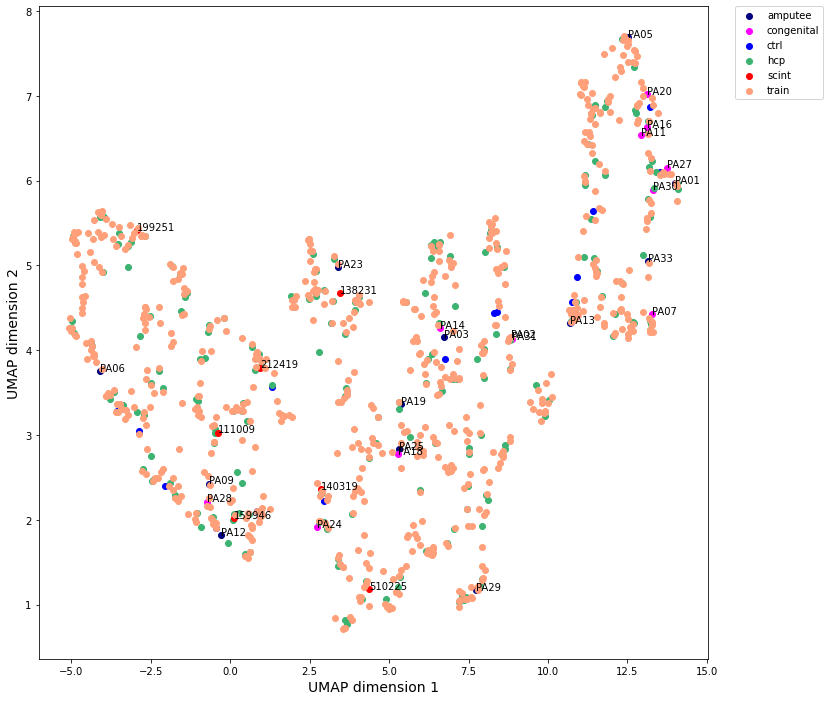

In [49]:
arr = embedding_all
labels_all = np.concatenate((labels, np.array(['train' for k in range(len(X_train))])))
color_dict = {'hcp':'mediumseagreen', 'scint': 'red', 'ctrl': 'blue', 'congenital':'magenta', 'amputee': 'navy', 'train':'lightsalmon'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

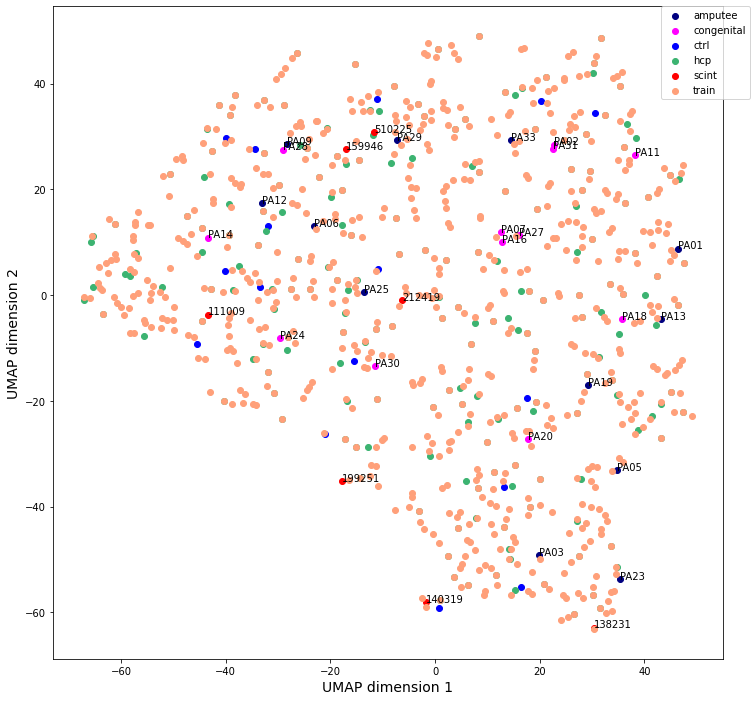

In [179]:
X_embedded = TSNE(n_components=2, random_state=12, perplexity=15).fit_transform(np.concatenate((X, X_train)))
arr = X_embedded
labels_all = np.concatenate((labels, np.array(['train' for k in range(len(X_train))])))
color_dict = {'hcp':'mediumseagreen', 'scint': 'red', 'ctrl': 'blue', 'congenital':'magenta', 'amputee': 'navy', 'train':'lightsalmon'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

In [50]:
clf = OneClassSVM(kernel='linear',gamma='auto', nu=0.2).fit(X_train)

In [51]:
Lsf = list(clf.decision_function(X))

#### LOF

In [52]:
from sklearn.neighbors import LocalOutlierFactor

In [53]:
clf = LocalOutlierFactor(n_neighbors=10, novelty=True, contamination=0.15).fit(X_train)

In [54]:
clf_pred = clf.predict(X)

##### Distance to nn

In [55]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)

In [56]:
distances, indices = nbrs.kneighbors(X)

In [57]:
Lnn = [np.mean(distances[k][1:]) for k in range(len(Lbvae))] 

In [58]:
anomaly_score = pd.DataFrame(list(zip(subjects_name_tot, Lbvae, clf_pred)), columns=['subjects', 'loss', 'lof'])

In [59]:
df_encoded['subjects'] = subjects_name_tot

In [60]:
abnormal = pd.merge(df_encoded, anomaly_score[anomaly_score.lof==-1], left_on='subjects', right_on='subjects')

In [61]:
abnormal.sort_values(by='loss')

,latent,Group,subjects,loss,lof
28,"[8.172136, -0.85020345, 5.8215084, -6.7793756]",amputee,PA13,2879,-1
13,"[6.576117, -0.73677874, 4.9602056, -5.5334263]",hcp,293748,3485,-1
22,"[5.9894967, 0.16217376, 3.3709638, -4.761141]",ctrl,PC02,3547,-1
30,"[6.760891, 0.37679362, 4.4973145, -5.2133355]",congenital,PA02,3555,-1
0,"[6.381909, -0.4479773, 5.146096, -5.297799]",hcp,115320,3584,-1
10,"[5.639592, -0.18482915, 5.0237513, -4.9570446]",hcp,397154,3699,-1
25,"[5.906303, 0.5736821, 3.5690777, -4.979935]",amputee,PA06,3703,-1
27,"[5.6905317, -1.643522, 3.1657245, -4.8912635]",amputee,PA23,3716,-1
29,"[5.512599, 1.4211987, 2.957708, -4.3434753]",amputee,PA12,3867,-1
23,"[5.5086126, 1.6818639, 3.6261454, -3.7375946]",ctrl,PC22,3903,-1


In [62]:
df_encoded['lof_score'] = clf.decision_function(X)

In [63]:
df_encoded[df_encoded.lof_score<0.001].sort_values(by='lof_score')

,latent,Group,subjects,lof_score
231,"[8.172136, -0.85020345, 5.8215084, -6.7793756]",amputee,PA13,-2.595997
236,"[6.760891, 0.37679362, 4.4973145, -5.2133355]",congenital,PA02,-0.606181
216,"[5.9894967, 0.16217376, 3.3709638, -4.761141]",ctrl,PC02,-0.502741
233,"[5.512599, 1.4211987, 2.957708, -4.3434753]",amputee,PA12,-0.334146
225,"[5.906303, 0.5736821, 3.5690777, -4.979935]",amputee,PA06,-0.314293
15,"[4.0315027, 1.3708682, 2.5282958, -3.4331539]",hcp,159441,-0.264952
187,"[4.210802, 6.0115833, 4.17695, -2.5449185]",hcp,204420,-0.244943
244,"[5.625784, 3.977969, 3.9788768, -3.9986005]",congenital,PA28,-0.202413
89,"[4.1620417, 2.19961, 2.9578795, -3.190819]",hcp,599469,-0.175309
156,"[6.576117, -0.73677874, 4.9602056, -5.5334263]",hcp,293748,-0.161514


In [194]:
X_abnor = np.array(list(abnormal['latent']))
embedding = reducer.transform(X_abnor)
labels = np.array(list(abnormal.Group))
arr = embedding

color_dict = {0:'mediumseagreen', 1: 'red', 2: 'blue', 3:'magenta', 4: 'navy', 5:'indianred', 6:'forestgreen', 
            7: 'chartreuse', 8:'slategrey', 9:'blueviolet'}
cluster = abnormal.cluster
marker_dict = {'hcp':'o', 'scint': 'x', 'ctrl': '+', 'congenital':'d', 'amputee': 'v'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(cluster):
    ix = np.where(cluster == g)
    #print(ix)
    #print([labels[ix[0]][k][0] for k in range(len(ix[0]))])
    #mark = [labels[ix][k][0] for k in range(len(ix[0]))]
    for point in range(len(ix[0])):
        #x = [arr[ix][k][0] for k in range(len(ix[0]))]
        #y = [arr[ix][k][1] for k in range(len(ix[0]))]
        x = arr[ix][point][0]
        y = arr[ix][point][1]
        mark = labels[ix][point]
        #g_lab= f"{g}"
        ax.scatter(x, y, c = color_dict[g], label = mark, marker=marker_dict[mark], s=60)
    
for i, txt in enumerate(list(abnormal.subjects)):
    ax.annotate(txt, (arr[i][0], arr[i][1]))

    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'cluster'

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

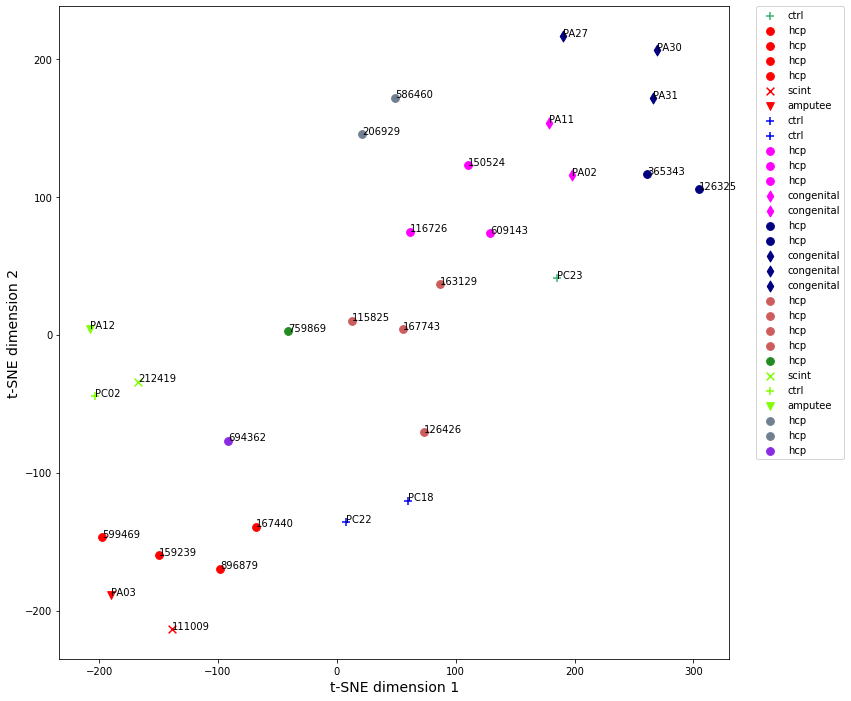

In [200]:
embedding = TSNE(n_components=2, random_state=12, perplexity=8).fit_transform(X_abnor)

labels = np.array(list(abnormal.Group))
arr = embedding

color_dict = {0:'mediumseagreen', 1: 'red', 2: 'blue', 3:'magenta', 4: 'navy', 5:'indianred', 6:'forestgreen', 
            7: 'chartreuse', 8:'slategrey', 9:'blueviolet'}
cluster = abnormal.cluster
marker_dict = {'hcp':'o', 'scint': 'x', 'ctrl': '+', 'congenital':'d', 'amputee': 'v'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(cluster):
    ix = np.where(cluster == g)
    #print(ix)
    #print([labels[ix[0]][k][0] for k in range(len(ix[0]))])
    #mark = [labels[ix][k][0] for k in range(len(ix[0]))]
    for point in range(len(ix[0])):
        #x = [arr[ix][k][0] for k in range(len(ix[0]))]
        #y = [arr[ix][k][1] for k in range(len(ix[0]))]
        x = arr[ix][point][0]
        y = arr[ix][point][1]
        mark = labels[ix][point]
        #g_lab= f"{g}"
        ax.scatter(x, y, c = color_dict[g], label = mark, marker=marker_dict[mark], s=60)
    
for i, txt in enumerate(list(abnormal.subjects)):
    ax.annotate(txt, (arr[i][0], arr[i][1]))

    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f't-SNE dimension 1', fontsize=14)
plt.ylabel(f't-SNE dimension 2', fontsize=14)
plt.show()

In [195]:
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score

For n_clusters = 2 The average silhouette_score with kmeans is : 0.19421858
For n_clusters = 3 The average silhouette_score with kmeans is : 0.16275294
For n_clusters = 4 The average silhouette_score with kmeans is : 0.17249237
For n_clusters = 5 The average silhouette_score with kmeans is : 0.17664534
For n_clusters = 6 The average silhouette_score with kmeans is : 0.19345371
For n_clusters = 7 The average silhouette_score with kmeans is : 0.15069696
For n_clusters = 8 The average silhouette_score with kmeans is : 0.15406266
For n_clusters = 9 The average silhouette_score with kmeans is : 0.1552218
For n_clusters = 10 The average silhouette_score with kmeans is : 0.15634258
For n_clusters = 11 The average silhouette_score with kmeans is : 0.16285542
For n_clusters = 12 The average silhouette_score with kmeans is : 0.15906419
For n_clusters = 13 The average silhouette_score with kmeans is : 0.16066036
For n_clusters = 14 The average silhouette_score with kmeans is : 0.15981665
For n_cl

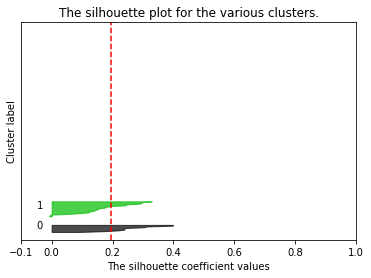

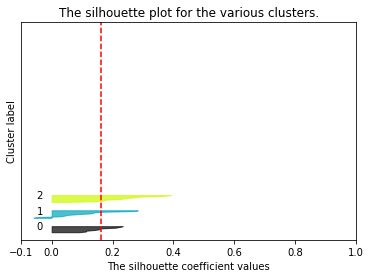

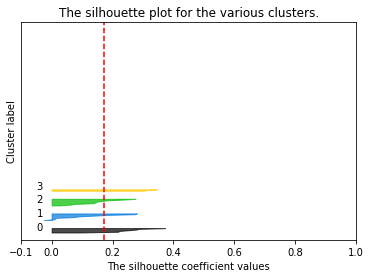

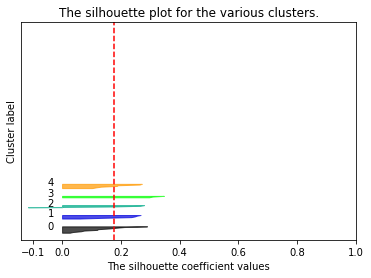

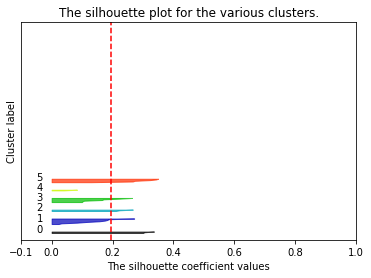

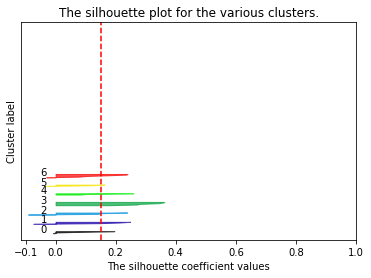

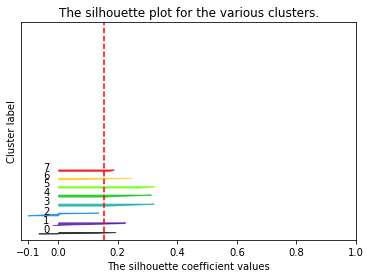

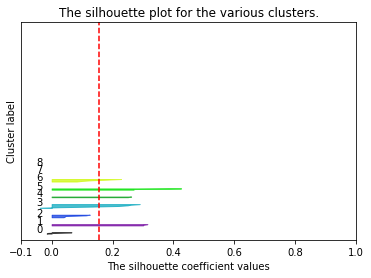

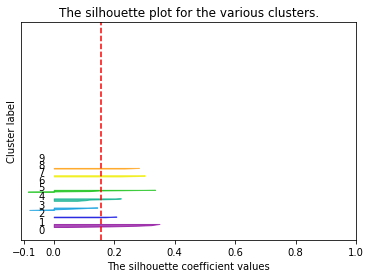

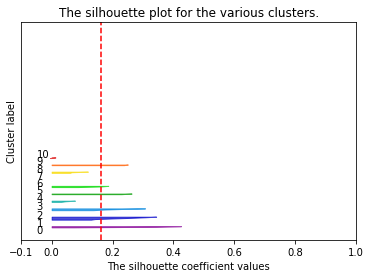

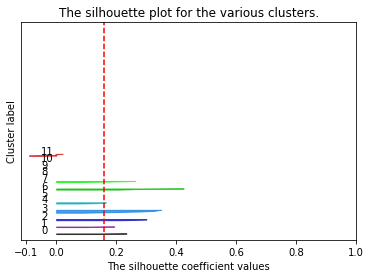

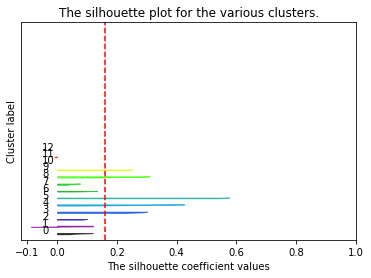

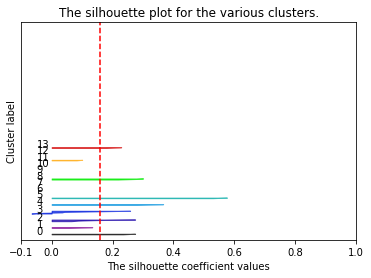

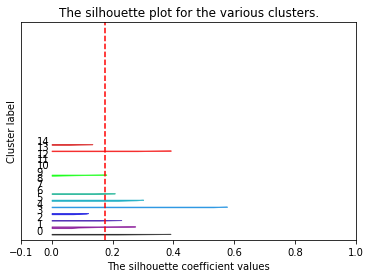

In [196]:
n_clusters_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n in n_clusters_list:
    cluster_labels= KMeans(n_clusters=n, random_state=0).fit_predict(X_abnor)

    fig, ax1 = plt.subplots()
    ax1.set_ylim([0, len(X) + (n + 1) * 10])
    silhouette_avg = silhouette_score(X_abnor, cluster_labels)
    print("For n_clusters =", n, "The average silhouette_score with kmeans is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_abnor, cluster_labels)

    y_lower = 10
    for i in range(n):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [197]:
cluster_labels= KMeans(n_clusters=10, random_state=0).fit_predict(X_abnor)

In [198]:
cluster_labels

array([6, 1, 4, 3, 4, 8, 8, 1, 1, 5, 5, 3, 3, 9, 5, 1, 5, 1, 7, 2, 0, 7,
       2, 1, 7, 4, 3, 4, 3, 4], dtype=int32)

In [199]:
abnormal['cluster'] = cluster_labels

In [131]:
abnormal[abnormal.cluster==3]

,latent,Group,subjects,loss,nn,sf,lof,a_score,cluster
4,"[2.2472699, 0.30434123, -1.8338748, 3.9089785,...",hcp,130821,4373,3.780491,-64.977450,-1,134.695857,3
5,"[-0.5731338, 0.7889283, -3.395938, 2.7438216, ...",hcp,599469,3968,3.484857,-60.822139,-1,126.000649,3
16,"[0.70559937, 1.4728817, -3.4144888, 2.624808, ...",hcp,159239,4419,3.293029,-141.041806,-1,286.347209,3
26,"[1.1525759, 0.6357797, -1.7769752, 2.047963, 0...",scint,111009,4553,3.106856,-115.659865,-1,235.426585,3


In [122]:
cluster_labels= KMeans(n_clusters=3, random_state=0).fit_predict(X_abnor)
abnormal['cluster'] = cluster_labels

In [356]:
abnormal[abnormal.cluster==9]

,latent,Group,subjects,loss,nn,sf,lof,a_score,cluster
10,"[2.4475284, -3.4358513, 0.9387543, 1.4231597, ...",hcp,810439,3957,2.909074,-89.331883,-1,182.441937,9
13,"[0.04080078, -4.0020103, 0.48344234, 0.1846454...",hcp,609143,3248,3.361013,-346.583756,-1,697.241900,9
18,"[-0.74268883, -3.2556813, -0.22183056, 0.86715...",hcp,163129,3575,3.127581,109.930926,-1,-215.949073,9
23,"[0.5436521, -3.6671193, -0.44985706, 1.0155271...",hcp,105923,3937,2.818244,49.756492,-1,-95.830035,9


### Reconstructions

In [134]:
z0 = [np.mean([abnormal.latent[k][i] for k in range(len(abnormal)) if list(abnormal.cluster)[k]==0]) for i in range(10)]
print(z0)

z4 = [np.mean([abnormal.latent[k][i] for k in range(len(abnormal)) if list(abnormal.cluster)[k]==4]) for i in range(10)]
print(z4)

[-0.057729226, 0.019369831, 0.41063666, 3.1779537, 1.1180569, -2.1365812, 2.0469081, 1.6159005, 0.15550554, 0.65777165]
[1.5605457, -3.0517354, -2.1927452, 2.5223696, 1.034786, 0.8640467, 0.31865478, 0.88094807, -1.3999795, 1.2780876]


In [138]:
z1 = [np.mean([abnormal.latent[k][i] for k in range(len(abnormal)) if list(abnormal.cluster)[k]==1]) for i in range(10)]
print(z0)

z2 = [np.mean([abnormal.latent[k][i] for k in range(len(abnormal)) if list(abnormal.cluster)[k]==2]) for i in range(10)]
print(z4)

z3 = [np.mean([abnormal.latent[k][i] for k in range(len(abnormal)) if list(abnormal.cluster)[k]==3]) for i in range(10)]
print(z0)

z6 = [np.mean([abnormal.latent[k][i] for k in range(len(abnormal)) if list(abnormal.cluster)[k]==6]) for i in range(10)]
print(z4)

z7 = [np.mean([abnormal.latent[k][i] for k in range(len(abnormal)) if list(abnormal.cluster)[k]==7]) for i in range(10)]
print(z0)

z8 = [np.mean([abnormal.latent[k][i] for k in range(len(abnormal)) if list(abnormal.cluster)[k]==9]) for i in range(10)]
print(z4)

[-0.057729226, 0.019369831, 0.41063666, 3.1779537, 1.1180569, -2.1365812, 2.0469081, 1.6159005, 0.15550554, 0.65777165]
[1.5605457, -3.0517354, -2.1927452, 2.5223696, 1.034786, 0.8640467, 0.31865478, 0.88094807, -1.3999795, 1.2780876]
[-0.057729226, 0.019369831, 0.41063666, 3.1779537, 1.1180569, -2.1365812, 2.0469081, 1.6159005, 0.15550554, 0.65777165]
[1.5605457, -3.0517354, -2.1927452, 2.5223696, 1.034786, 0.8640467, 0.31865478, 0.88094807, -1.3999795, 1.2780876]
[-0.057729226, 0.019369831, 0.41063666, 3.1779537, 1.1180569, -2.1365812, 2.0469081, 1.6159005, 0.15550554, 0.65777165]
[1.5605457, -3.0517354, -2.1927452, 2.5223696, 1.034786, 0.8640467, 0.31865478, 0.88094807, -1.3999795, 1.2780876]


In [135]:
z5 = [np.mean([abnormal.latent[k][i] for k in range(len(abnormal)) if list(abnormal.cluster)[k]==5]) for i in range(10)]
print(z5)

z8 = [np.mean([abnormal.latent[k][i] for k in range(len(abnormal)) if list(abnormal.cluster)[k]==8]) for i in range(10)]
print(z8)

[1.4576374, -0.86520636, -0.6617214, -0.32259452, 1.9742482, -1.2503551, 3.5093257, 1.1488994, -0.61514515, 1.6285467]
[1.308041, -0.08524938, -1.6842239, 0.88843125, 2.5763, -0.22308488, 1.956274, 0.7264746, -2.3611698, -0.48263615]


In [136]:
arr_out = []
values = []
for enc, lab in zip([z0, z4, z5, z8], ['c0', 'c4', 'c5', 'c8']):
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(lab)

arr_out = np.array(arr_out)
np.save(f"/volatile/arr_out.npy", arr_out)
np.save('/volatile/arr_label.npy', np.array(values))

In [137]:
for k in range(4):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"/volatile/bucket_cluster{k}.bck")

In [141]:
arr_out = []
values = []
for enc, lab in zip([z1, z2, z3, z6, z7, z8], ['c1', 'c2', 'c3', 'c6', 'c7', 'c9']):
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(lab)

arr_out = np.array(arr_out)
np.save(f"/volatile/arr_out.npy", arr_out)
np.save('/volatile/arr_label.npy', np.array(values))

In [142]:
for k, i in enumerate([1, 2,3,6,7,9]):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"/volatile/bucket_cluster{i}.bck")

### Going from control centroid to one abnormal cluster

In [208]:
z2

[-0.93279177,
 -0.40741763,
 -2.168207,
 2.3000393,
 2.89409,
 -1.1772474,
 0.4227159,
 -0.32224128,
 -1.9756174,
 0.43747678]

In [205]:
z_train = [np.mean([X_train[k][i] for k in range(len(X_train))]) for i in range(10)]
print(z_train)

[1.159973, -0.9406189, -1.4649181, 1.4306669, 1.4758445, -1.1576344, 1.1078352, 1.0203571, -1.3120298, 1.2407905]


In [221]:
dim0 = [z2[0]] + [z2[0] + ((z_train[0]-z2[0])/5)*k for k in [1,2,3,4]] + [z_train[0]]
dim1 = [z2[1]] + [z2[1] + ((z_train[1]-z2[1])/5)*k for k in [1,2,3,4]] + [z_train[1]]
dim2 = [z2[2]] + [z2[2] + ((z_train[2]-z2[2])/5)*k for k in [1,2,3,4]] + [z_train[2]]
dim3 = [z2[3]] + [z2[3] + ((z_train[3]-z2[3])/5)*k for k in [1,2,3,4]] + [z_train[3]]
dim4 = [z2[4]] + [z2[4] + ((z_train[4]-z2[4])/5)*k for k in [1,2,3,4]] + [z_train[4]]
dim5 = [z2[5]] + [z2[5] + ((z_train[5]-z2[5])/5)*k for k in [1,2,3,4]] + [z_train[5]]
dim6 = [z2[6]] + [z2[6] + ((z_train[6]-z2[6])/5)*k for k in [1,2,3,4]] + [z_train[6]]
dim7 = [z2[7]] + [z2[7] + ((z_train[7]-z2[7])/5)*k for k in [1,2,3,4]] + [z_train[7]]
dim8 = [z2[8]] + [z2[8] + ((z_train[8]-z2[8])/5)*k for k in [1,2,3,4]] + [z_train[8]]
dim9 = [z2[9]] + [z2[9] + ((z_train[9]-z2[9])/5)*k for k in [1,2,3,4]] + [z_train[9]]

In [226]:
src_dir ='/neurospin/dico/lguillon/miccai_22/analyses_gridsearch/'
arr_out = []
values = []

for k in range(6):
    enc = [dim0[k], dim1[k], dim2[k], dim3[k], dim4[k], dim5[k], dim6[k], dim7[k], dim8[k], dim9[k]]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(f"step_{k}")

arr_out = np.array(arr_out)
#np.save(f"/neurospin/dico/lguillon/midl_22/visu_cluster_gen/interpolation_0_1.npy", arr_out)
#np.save('/neurospin/dico/lguillon/midl_22/visu_cluster_gen/label_interpolation_0_1.npy', np.array(values))
for k in range(6):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"{src_dir}cluster_train_2/interpolation_bucket_step_{k}.bck")

#### From train to 9

In [353]:
dim0 = [z9[0]] + [z9[0] + ((z_train[0]-z9[0])/5)*k for k in [1,2,3,4]] + [z_train[0]]
dim1 = [z9[1]] + [z9[1] + ((z_train[1]-z9[1])/5)*k for k in [1,2,3,4]] + [z_train[1]]
dim2 = [z9[2]] + [z9[2] + ((z_train[2]-z9[2])/5)*k for k in [1,2,3,4]] + [z_train[2]]
dim3 = [z9[3]] + [z9[3] + ((z_train[3]-z9[3])/5)*k for k in [1,2,3,4]] + [z_train[3]]
dim4 = [z9[4]] + [z9[4] + ((z_train[4]-z9[4])/5)*k for k in [1,2,3,4]] + [z_train[4]]
dim5 = [z9[5]] + [z9[5] + ((z_train[5]-z9[5])/5)*k for k in [1,2,3,4]] + [z_train[5]]
dim6 = [z9[6]] + [z9[6] + ((z_train[6]-z9[6])/5)*k for k in [1,2,3,4]] + [z_train[6]]
dim7 = [z9[7]] + [z9[7] + ((z_train[7]-z9[7])/5)*k for k in [1,2,3,4]] + [z_train[7]]
dim8 = [z9[8]] + [z9[8] + ((z_train[8]-z9[8])/5)*k for k in [1,2,3,4]] + [z_train[8]]
dim9 = [z9[9]] + [z9[9] + ((z_train[9]-z9[9])/5)*k for k in [1,2,3,4]] + [z_train[9]]

In [355]:
src_dir ='/neurospin/dico/lguillon/miccai_22/analyses_gridsearch/'
arr_out = []
values = []

for k in range(6):
    enc = [dim0[k], dim1[k], dim2[k], dim3[k], dim4[k], dim5[k], dim6[k], dim7[k], dim8[k], dim9[k]]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(f"step_{k}")

arr_out = np.array(arr_out)
#np.save(f"/neurospin/dico/lguillon/midl_22/visu_cluster_gen/interpolation_0_1.npy", arr_out)
#np.save('/neurospin/dico/lguillon/midl_22/visu_cluster_gen/label_interpolation_0_1.npy', np.array(values))
for k in range(6):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"{src_dir}cluster_train_9/interpolation_bucket_step_{k}.bck")

#### From train to 8

In [358]:
dim0 = [z8[0]] + [z8[0] + ((z_train[0]-z8[0])/5)*k for k in [1,2,3,4]] + [z_train[0]]
dim1 = [z8[1]] + [z8[1] + ((z_train[1]-z8[1])/5)*k for k in [1,2,3,4]] + [z_train[1]]
dim2 = [z8[2]] + [z8[2] + ((z_train[2]-z8[2])/5)*k for k in [1,2,3,4]] + [z_train[2]]
dim3 = [z8[3]] + [z8[3] + ((z_train[3]-z8[3])/5)*k for k in [1,2,3,4]] + [z_train[3]]
dim4 = [z8[4]] + [z8[4] + ((z_train[4]-z8[4])/5)*k for k in [1,2,3,4]] + [z_train[4]]
dim5 = [z8[5]] + [z8[5] + ((z_train[5]-z8[5])/5)*k for k in [1,2,3,4]] + [z_train[5]]
dim6 = [z8[6]] + [z8[6] + ((z_train[6]-z8[6])/5)*k for k in [1,2,3,4]] + [z_train[6]]
dim7 = [z8[7]] + [z8[7] + ((z_train[7]-z8[7])/5)*k for k in [1,2,3,4]] + [z_train[7]]
dim8 = [z8[8]] + [z8[8] + ((z_train[8]-z8[8])/5)*k for k in [1,2,3,4]] + [z_train[8]]
dim9 = [z8[9]] + [z8[9] + ((z_train[9]-z8[9])/5)*k for k in [1,2,3,4]] + [z_train[9]]

In [359]:
src_dir ='/neurospin/dico/lguillon/miccai_22/analyses_gridsearch/'
arr_out = []
values = []

for k in range(6):
    enc = [dim0[k], dim1[k], dim2[k], dim3[k], dim4[k], dim5[k], dim6[k], dim7[k], dim8[k], dim9[k]]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(f"step_{k}")

arr_out = np.array(arr_out)
#np.save(f"/neurospin/dico/lguillon/midl_22/visu_cluster_gen/interpolation_0_1.npy", arr_out)
#np.save('/neurospin/dico/lguillon/midl_22/visu_cluster_gen/label_interpolation_0_1.npy', np.array(values))
for k in range(6):
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(arr_out[k]), voxel_size=(2,2,2)), f"{src_dir}cluster_train_8/interpolation_bucket_step_{k}.bck")

### Classification

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [201]:
X_hand = np.concatenate((encoded['congenital'], encoded['ctrl'], encoded['amputee']))
label_hand = np.array(['cong' for k in range(len(encoded['congenital']))]+['ctrl' for k in range(len(encoded['ctrl']))]+ ['ctrl' for k in range(len(encoded['amputee']))])

X_train, X_test, y_train, y_test = train_test_split(X_hand, label_hand, test_size=0.4, stratify=label_hand, random_state=42)

              precision    recall  f1-score   support

        cong       0.33      0.50      0.40         2
        ctrl       0.80      0.67      0.73         6

    accuracy                           0.62         8
   macro avg       0.57      0.58      0.56         8
weighted avg       0.68      0.62      0.65         8

0.625
              precision    recall  f1-score   support

        cong       0.33      0.50      0.40         2
        ctrl       0.80      0.67      0.73         6

    accuracy                           0.62         8
   macro avg       0.57      0.58      0.56         8
weighted avg       0.68      0.62      0.65         8

0.625
              precision    recall  f1-score   support

        cong       0.00      0.00      0.00         2
        ctrl       0.67      0.67      0.67         6

    accuracy                           0.50         8
   macro avg       0.33      0.33      0.33         8
weighted avg       0.50      0.50      0.50         8

0.5
   

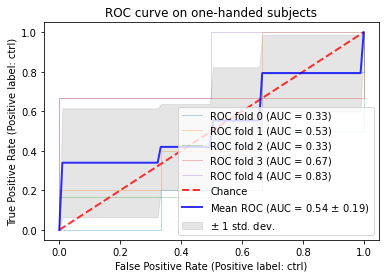

In [202]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5)
#gb = GradientBoostingClassifier(random_state=0, loss='deviance', n_estimators=200, max_depth=10)
gb = LogisticRegression(random_state=0, max_iter=1000)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X_hand, label_hand)):
    gb.fit(X_hand[train], label_hand[train])
    print(metrics.classification_report(gb.predict(X_hand[test]), label_hand[test]))
    print(gb.score(X_hand[test], label_hand[test]))
    viz = metrics.plot_roc_curve(gb, X_hand[test], label_hand[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve on one-handed subjects")
ax.legend(loc="lower right")
plt.show()

In [255]:
len(encoded['ctrl'])+len(encoded['amputee'])+len(encoded['congenital'])

40

In [413]:
def draw_random_roc(y_true, num_classif=1000):
    """
    Draws the ROC curve and 95% confidence interval (2*std dev) for
    num_classif (default 1000) random classifiers
    """
    chance_tprs = []
    chance_aucs = []
    base_fpr = np.linspace(0, 1, 100)
    for i in range(1000):
        random.seed(i)
        y_pred = coin_toss(len(y_true))
        fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
        chance_tprs.append(np.interp(base_fpr, fpr, tpr))
        chance_tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        chance_aucs.append(roc_auc)
        # plt.plot(fpr, tpr, lw=1, alpha=0.3,
        #           label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    # plt.show()

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(base_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax = plt.subplot()
    for i, (train, test) in enumerate(cv.split(X_hand, label_hand)):
        gb.fit(X_hand[train], label_hand[train])
        print(metrics.classification_report(gb.predict(X_hand[test]), label_hand[test]))
        print(gb.score(X_hand[test], label_hand[test]))
        viz = metrics.plot_roc_curve(gb, X_hand[test], label_hand[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
    ax.plot(base_fpr, mean_tpr, color='r',
             label=r'chance (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, linestyle='dashed')
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
    # plot confidence interval 95%
    low_auc = np.sort(chance_aucs)[50]
    high_auc = np.sort(chance_aucs)[950]
    tprs_lower = chance_tprs[chance_aucs.index(low_auc)]
    tprs_upper = chance_tprs[chance_aucs.index(high_auc)]
    ax.plot(base_fpr, tprs_lower, color='grey', linestyle='dashed', label='95% confidence interval')
    ax.plot(base_fpr, tprs_upper, color='grey', linestyle='dashed')
    # std_tpr = np.std(tprs, axis=0)
    # tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
    # tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
    # ax.plot(base_fpr, tprs_lower, color='grey', linestyle='dashed',
    #                  label=r'luck $\pm$ 2 std. dev.')
    # ax.plot(base_fpr, tprs_upper, color='grey', linestyle='dashed')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    # ax.title('ROC Curve for 1000 random classifiers')
    # ax.legend(loc="lower right")
    return ax

def coin_toss(number):
    results = []
    for i in range(number):
        res = random.randint(0,1)
        results.append(res)
    return results

In [398]:
label_hand_num = [0 if label_hand[k]=='ctrl' else 1 for k in range(len(label_hand))]

              precision    recall  f1-score   support

        cong       0.67      1.00      0.80         2
        ctrl       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8

0.875
              precision    recall  f1-score   support

        cong       0.67      0.67      0.67         3
        ctrl       0.80      0.80      0.80         5

    accuracy                           0.75         8
   macro avg       0.73      0.73      0.73         8
weighted avg       0.75      0.75      0.75         8

0.75
              precision    recall  f1-score   support

        cong       0.50      0.33      0.40         3
        ctrl       0.67      0.80      0.73         5

    accuracy                           0.62         8
   macro avg       0.58      0.57      0.56         8
weighted avg       0.60      0.62      0.60         8

0.625
  

<AxesSubplot:xlabel='False Positive Rate', ylabel='True Positive Rate'>

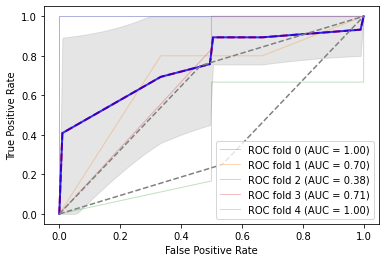

In [414]:
import random
label_random
draw_random_roc(label_hand_num)

In [256]:
len(encoded['congenital'])

12

In [257]:
28/40

0.7

In [380]:
from tqdm import tqdm
random_score = []
for k in tqdm(range(1000)):
    label_random = np.random.permutation(label_hand)
    cv = StratifiedKFold(n_splits=5)
    gb = GradientBoostingClassifier(random_state=0, loss='deviance', n_estimators=200, max_depth=5)
    x_train, x_test, y_train, y_test = train_test_split(X_hand, label_random, test_size=0.4, stratify=label_random)
    #for i, (train, test) in enumerate(cv.split(X_hand, label_random)):
    #    gb.fit(X_hand[train], label_random[train])
    #    random_score.append(gb.score(X_hand[test], label_random[test]))
    gb.fit(x_train, y_train)
    random_score.append(gb.score(x_test, y_test))
print(np.mean(random_score))
print(np.std(random_score))

100%|██████████| 1000/1000 [01:20<00:00, 12.43it/s]

0.5766875
0.12066662170521723


In [378]:
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(random_score, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(random_score, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

95.0 confidence interval 37.5% and 87.5%


In [341]:
len(random_score)

1000

(array([  1.,  13.,   0.,  39.,  86., 166., 246., 271., 176.,   2.]),
 array([0.16666667, 0.25      , 0.33333333, 0.41666667, 0.5       ,
        0.58333333, 0.66666667, 0.75      , 0.83333333, 0.91666667,
        1.        ]),
 <BarContainer object of 10 artists>)

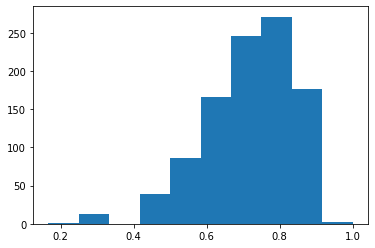

In [352]:
plt.hist(random_score)

In [344]:
random_score_sort = random_score.sort()

In [345]:
print(random_score[25], random_score[975])

0.375 1.0


In [308]:
np.mean(random_score)

0.5741

In [379]:
from tqdm import tqdm
inter_score = []
for k in tqdm(range(1000)):
    cv = StratifiedKFold(n_splits=5)
    gb = GradientBoostingClassifier(random_state=0, loss='deviance', n_estimators=200, max_depth=5)
    x_train, x_test, y_train, y_test = train_test_split(X_hand, label_hand, test_size=0.4, stratify=label_hand)
    #for i, (train, test) in enumerate(cv.split(X_hand, label_hand)):
    #   gb.fit(X_hand[train], label_hand[train])
    #    #print(gb.score(X_hand[test], label_hand[test]))
    #    inter_score.append(gb.score(X_hand[test], label_hand[test]))
    gb.fit(x_train, y_train)
    inter_score.append(gb.score(x_test, y_test))
print(np.mean(inter_score))
print(np.std(inter_score))

100%|██████████| 1000/1000 [01:17<00:00, 12.94it/s]

0.666125
0.12213971252217683


(array([  1.,   9.,   0.,  36.,  80., 178., 218., 285., 192.,   1.]),
 array([0.16666667, 0.25      , 0.33333333, 0.41666667, 0.5       ,
        0.58333333, 0.66666667, 0.75      , 0.83333333, 0.91666667,
        1.        ]),
 <BarContainer object of 10 artists>)

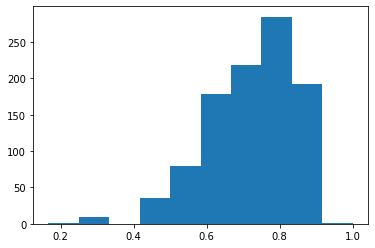

In [351]:
plt.hist(inter_score)

In [381]:
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(inter_score, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(inter_score, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

95.0 confidence interval 37.5% and 87.5%


### Indicators correlation

In [383]:
abnormal

,latent,Group,subjects,loss,nn,sf,lof,a_score,cluster
0,"[1.3628325, -1.4742346, -2.2796068, 0.99431926...",hcp,108020,4147,2.774021,73.982398,-1,-144.279947,8
1,"[1.0810305, -0.57689613, -2.219369, 0.5845616,...",hcp,201414,3906,3.063100,182.582539,-1,-361.244082,8
2,"[0.72362673, -2.1792939, -2.3081293, 3.8330557...",hcp,112516,4103,2.890668,478.260917,-1,-952.730001,4
3,"[-0.27710456, -0.767203, 0.9066349, 1.9264593,...",hcp,586460,4001,2.890378,-233.608077,-1,470.985292,0
4,"[2.2472699, 0.30434123, -1.8338748, 3.9089785,...",hcp,130821,4373,3.780491,-64.977450,-1,134.695857,3
5,"[-0.5731338, 0.7889283, -3.395938, 2.7438216, ...",hcp,599469,3968,3.484857,-60.822139,-1,126.000649,3
6,"[-1.0190464, 0.6831233, -2.0079532, -0.2097208...",hcp,654754,3336,3.056104,258.093625,-1,-512.398442,7
7,"[3.7260022, -0.83962566, -2.6405907, 0.2219044...",hcp,837560,3732,2.501834,334.725737,-1,-666.129961,1
8,"[1.307236, -0.01614024, -1.1279445, 0.53016156...",hcp,140117,3543,2.941968,-93.794183,-1,191.308502,8
9,"[0.97864217, -3.9293244, -1.7890984, 1.9125583...",hcp,203721,3439,3.104936,-0.000332,-1,3.860927,4


In [382]:
import seaborn as sns

<AxesSubplot:>

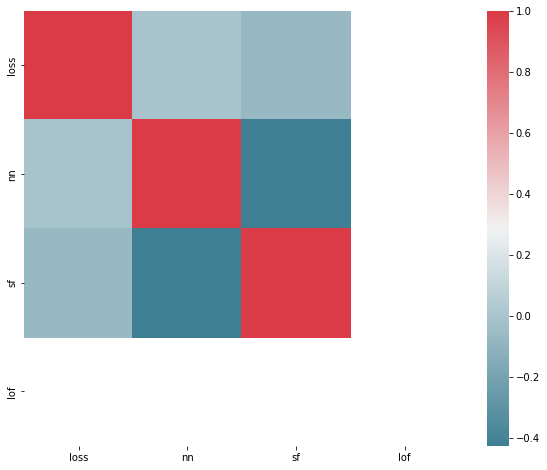

In [385]:
f, ax = plt.subplots(figsize=(10, 8))
corr = abnormal[['loss', 'nn', 'sf', 'lof']].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

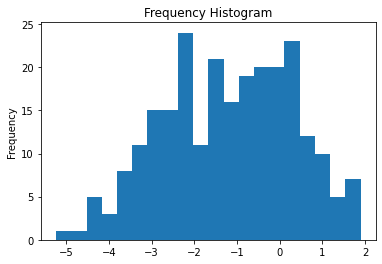

In [225]:
range_values_dim_1 = [k[0] for k in X] 
range_values_dim_2 = [k[1] for k in X] 
fig = plt.figure()
#plt.hist(range_values_dim_1, bins=20)
plt.hist(range_values_dim_2, bins=20)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [220]:
z1 = np.arange(2, 3, 0.15)
z2 = np.arange(-5, 2, 1)

In [203]:
z1

array([-5, -4, -3, -2, -1,  0,  1])

In [210]:
z2

array([2.  , 2.15, 2.3 , 2.45, 2.6 , 2.75, 2.9 ])

In [226]:
arr_out2 = []
values2= []
mean = torch.randn((1,4), device=device)
logvar = torch.randn((1,4), device=device)
z = VAE.sample_z(model, mean, logvar)
    
for dim_1 in z1:
    for dim_10 in z2:
        z[0][0] = dim_1
        z[0][1] = dim_10
        out = model.decode(z)
        output = torch.argmax(out, dim=1)
        out = np.array(np.squeeze(output).cpu().detach().numpy())
        arr_out2.append(out)
        values2.append((dim_1, dim_10))
    
arr_out2 = np.array(arr_out2)

np.save(f"/volatile/arr_out.npy", arr_out2)
np.save('/volatile/arr_label.npy', np.array(values2))

In [223]:
z.shape

torch.Size([1, 4])

In [211]:
arr_out = []
values = []
for enc, lab in zip([z1, z2], ['c0', 'c1']):
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    output = torch.argmax(out, dim=1)
    out = np.array(np.squeeze(output).cpu().detach().numpy())
    arr_out.append(out)
    values.append(lab)

arr_out = np.array(arr_out)
np.save(f"/volatile/arr_out.npy", arr_out)
np.save('/volatile/arr_label.npy', np.array(values))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x7 and 4x11200)

In [ ]:
        z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
        z = torch.unsqueeze(z, dim=0)
        out = model.decode(z)
        output = torch.argmax(out, dim=1)
        out = np.array(np.squeeze(output).cpu().detach().numpy())
        arr_out.append(out)
        values.append(lab)

In [75]:
#values_22 = np.arange(-1.5, 2, 0.5)
#values_88 = np.arange(-1.5, 2, 0.5)
arr_out2 = []
values= []
mean = torch.randn((1,2), device=device)
logvar = torch.randn((1,2), device=device)
z = model.sample_z(mean, logvar)
    
for dim_1 in z1:
    for dim_2 in z2:
        z[0][0] = dim_1
        z[0][1] = dim_2
        out = model.decode(z)
        output = torch.argmax(out, dim=1)
        out = np.array(np.squeeze(output).cpu().detach().numpy())
        arr_out2.append(out)
        values.append((dim_1, dim_2))
        
arr_out = np.array(arr_out2)
np.save(f"/volatile/arr_out_mic.npy", arr_out)
np.save('/volatile/arr_label_mic.npy', np.array(values))

In [76]:
arr_out.shape

(36, 40, 40, 56)